## Nation-Wide Data Science Jobscape

In [1]:
import pandas as pd
import numpy as np
import sklearn
import re
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from splinter import Browser
import scrapy

In [2]:
#Plotly
import plotly.express as px
import plotly.graph_objects as go

In [3]:
# base_url = f'https://www.onetonline.org/link/localjobs/15-2051.00?st={state}'

In [3]:
states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
            'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
            'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
            'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
            'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']

### Test

In [4]:
AL = pd.read_html(f'https://www.onetonline.org/link/localjobs/15-2051.00?st={states[1]}')
AL[0].head(5)

,Posted,Title and Company,Location
0,"May 13, 2023",Data ScientistFord Motor Company,"Juneau, AK"
1,"May 25, 2023",Senior Data ScientistHumana,"Anchorage, AK"
2,"June 3, 2023",Senior Data ScientistPearson,"Juneau, AK"
3,"May 26, 2023","Data Scientist, Product AnalyticsMeta","Juneau, AK"
4,"May 19, 2023","Data Scientist, Product AnalyticsMeta","Juneau, AK"


In [5]:
TABLES = []
for i in states:
    table = pd.read_html(f'https://www.onetonline.org/link/localjobs/15-2051.00?st={i}')
    TABLES.append(table[0])
TABLES

[            Posted                                  Title and Company  \
 0     May 13, 2023                   Data ScientistFord Motor Company   
 1     May 18, 2023                           Data ScientistGuidehouse   
 2   April 22, 2023                             Data ScientistDeloitte   
 3     May 18, 2023  Data Scientist and Applied MathematicianBooz A...   
 4     May 25, 2023                        Senior Data ScientistHumana   
 5     May 25, 2023                        Senior Data ScientistHumana   
 6     May 25, 2023                        Senior Data ScientistHumana   
 7     June 1, 2023                      Lead NLP Data ScientistHumana   
 8     June 3, 2023                       Senior Data ScientistPearson   
 9     May 26, 2023              Data Scientist, Product AnalyticsMeta   
 10    May 19, 2023              Data Scientist, Product AnalyticsMeta   
 11   April 6, 2023                   Cleared Data ScientistGuidehouse   
 12   April 7, 2023                HR 

In [6]:
df = pd.DataFrame()
for table in TABLES:
    df = pd.concat([df, table], axis=0)
df

,Posted,Title and Company,Location
0,"May 13, 2023",Data ScientistFord Motor Company,"Montgomery, AL"
1,"May 18, 2023",Data ScientistGuidehouse,"Huntsville, AL"
2,"April 22, 2023",Data ScientistDeloitte,"Birmingham, AL"
3,"May 18, 2023",Data Scientist and Applied MathematicianBooz A...,"Huntsville, AL"
4,"May 25, 2023",Senior Data ScientistHumana,"Birmingham, AL"
...,...,...,...
24,"May 20, 2023","Senior Data Scientist, Predictive Analytics/Ar...","Cheyenne, WY"
25,"May 24, 2023","Director, Data Science - Fraud DetectionTravel...","Cheyenne, WY"
26,"May 20, 2023",Data Engineer I - Data ModelerTravelers Insura...,"Cheyenne, WY"
27,"April 19, 2023",Data Analytics SpecialistCadmus,"Cheyenne, WY"


In [7]:
# Split the field at the point where lowercase and uppercase letters meet
pattern = r'(?<=[a-z])(?=[A-Z])'
df[['Title', 'Company']] = df['Title and Company'].str.split(pattern, n=1, expand=True)

# Remove any leading/trailing whitespaces
df['Title'] = df['Title'].str.strip()
df['Company'] = df['Company'].str.strip()

# Drop the 'Title and Company' Field
df.drop('Title and Company', axis=1, inplace=True)

# Split the Location field at the comma to create a City and State field
df[['City', 'State']] = df['Location'].str.split(',', n=1, expand=True)

# Remove any leading/trailing whitespace on the State and City fields values
df['State'] = df['State'].str.strip()
df['City'] = df['City'].str.strip()

# Do not drop the Location column in case of need for combined field while Mapping

# Reorder columns
df = df[['State', 'City', 'Title', 'Company', 'Posted', 'Location']]

# Inspect resulting df
df

,State,City,Title,Company,Posted,Location
0,AL,Montgomery,Data Scientist,Ford Motor Company,"May 13, 2023","Montgomery, AL"
1,AL,Huntsville,Data Scientist,Guidehouse,"May 18, 2023","Huntsville, AL"
2,AL,Birmingham,Data Scientist,Deloitte,"April 22, 2023","Birmingham, AL"
3,AL,Huntsville,Data Scientist and Applied Mathematician,Booz Allen Hamilton,"May 18, 2023","Huntsville, AL"
4,AL,Birmingham,Senior Data Scientist,Humana,"May 25, 2023","Birmingham, AL"
...,...,...,...,...,...,...
24,WY,Cheyenne,"Senior Data Scientist, Predictive Analytics/Ar...",None,"May 20, 2023","Cheyenne, WY"
25,WY,Cheyenne,"Director, Data Science - Fraud Detection",Travelers Insurance Company,"May 24, 2023","Cheyenne, WY"
26,WY,Cheyenne,Data Engineer I - Data Modeler,Travelers Insurance Company,"May 20, 2023","Cheyenne, WY"
27,WY,Cheyenne,Data Analytics Specialist,Cadmus,"April 19, 2023","Cheyenne, WY"


In [16]:
df.to_csv('us_ds_jobs.csv', index=False)

### Read in CSV

In [24]:
df = pd.read_csv('us_ds_jobs.csv')

In [25]:
state_gb = df.groupby('State', as_index=False)['Title'].count()
state_gb

,State,Title
0,AK,21
1,AL,33
2,AR,35
3,AZ,43
4,CA,102
5,CO,51
6,CT,35
7,D.C.,1
8,DC,37
9,DE,30


In [26]:
# Get the row index where State is 'D.C.'
index_to_drop = state_gb[state_gb['State'] == 'D.C.'].index

# Drop rows by index
state_gb_clean = state_gb.drop(index_to_drop)
state_gb_clean.head(10)

,State,Title
0,AK,21
1,AL,33
2,AR,35
3,AZ,43
4,CA,102
5,CO,51
6,CT,35
8,DC,37
9,DE,30
10,FL,76


In [27]:
state_gb_clean = state_gb_clean.rename(columns={'Title' : 'Current Number of Job Listings'})
state_gb_clean.columns

Index(['State', 'Current Number of Job Listings'], dtype='object')

<AxesSubplot:>

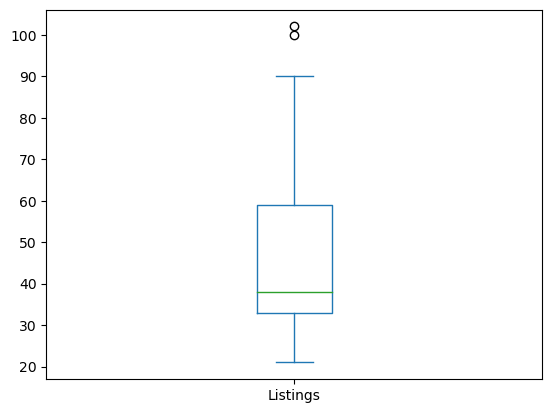

In [22]:
state_gb_clean.plot.box()

In [30]:
fig1 = px.choropleth(state_gb_clean,
                    locations='State',
                    color='Current Number of Job Listings',
                    color_continuous_scale='spectral_r',
                    hover_name='State',
                    locationmode='USA-states',
                    labels={'Choropleth Map of Data Science Job Listings by State'},
                    scope='usa')

# fig1.update_layout(
#     title=dict(text="Title", x=0.5, y=.95), title_font_size = 40
# )

fig1.show(renderer="chrome")

ValueError: Can't locate a browser with key in ('chrome', 'google-chrome')